In [ ]:
pip install langchain-experimental langchain_huggingface

In [ ]:
import subprocess
import os

import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from transformers import AutoTokenizer, AutoModelForCausalLM
# os.environ["CUDA_VISIBLE_DEVICES"]=""
DEVICE = torch.device("cuda")
torch.cuda.is_available()

# model_id = "Salesforce/codegen-2B-mono" 
    # 2B params, 170B tokens(Runs on P100)
# model_id = "bigcode/santacoder" 
    # GPT-2 based, 1.1B params, 236B tokens(Runs on P100)
model_id = "bigcode/starcoder2-3b" 
    # GPT-2 based, 3.03B params, 236B tokens, "State of art"(Runs on P100)
    # Has own special tokens for "fill-in-the-middle" completion

# Load a model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to("cuda")

In [ ]:
import transformers
from langchain_experimental.utilities import PythonREPL
from transformers import pipeline
from langchain_huggingface import HuggingFacePipeline
import re
import time 

prompt = "#Write and test bubblesort\ndef coolsort():"
llm = HuggingFacePipeline(pipeline=pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=100,
    temperature=0.1,
    repetition_penalty=1.2,
    return_full_text=True,
    pad_token_id=50256,
))
print(llm(prompt))

class CustomPipeline:
    """
        Specific self-contained pipeline
        Continously calls llm with prompt and validates it's output
    """
    def __init__(self,
                 tokenizer: transformers.CodeGenTokenizer | transformers.CodeGenTokenizerFast, 
                 model: transformers.CodeGenModel,
                 *,
                 max_iter: int,
                 enable_REPL: bool,
                 delete_funny_asian_words: bool,
                 verbose: int):
        self.tokenizer_ = tokenizer
        self.model_ = model
        self.max_iter_ = max_iter
        self.current_iter_ = 0
        self.REPL_ = PythonREPL()
        self.enable_REPL_ = enable_REPL
        self.delete_funny_asian_words_ = delete_funny_asian_words
        self.verbose_ = verbose
        self.was_valid_after_first_iter_ = False
        self.llm_ = HuggingFacePipeline(pipeline=pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=100,
            # temperature=0.3,
            repetition_penalty=1.8,
            do_sample=True,
            num_beams=2,
            return_full_text=True,
            pad_token_id=50256,
        ))
        
    def Generate(self, prompt: str):
        self.prompt_ = prompt
        self.is_valid_ = False
        self.retry_ = False
        self.was_valid_after_first_iter_ = False
        current_iter = 0
        while (
            current_iter < self.max_iter_ 
            and self.is_valid_ == False
        ):
            temp = self.prompt_
            self.__CallLLM()
            number = self.__ExecuteAndValidate()
            if (self.retry_ == True):
                self.prompt_ = temp
                self.retry_ = False
            else:
                if (number == -1 and current_iter == 0):
                    self.was_valid_after_first_iter_ = True
                    current_iter += 1
                    break
                if (self.verbose_ == 2):
                    print(
                        "================", 
                        current_iter, 
                        "================\n", 
                        self.prompt_, "\n"
                    )
            current_iter += 1
        return self.prompt_, current_iter, self.__AtWhatLineExecutionStops(self.REPL_.run(self.prompt_)), self.was_valid_after_first_iter_

    def __CallLLM(self):
        self.prompt_ = self.llm_(self.prompt_)
        
    def __AtWhatLineExecutionStops(self, analysis: str) -> int:
        line_patterns = [
            r'SyntaxError.*line (\d+)',
            r'\(.*?, (\d+),',
            r'line (\d+)'
        ]
        for pattern in line_patterns:
            match = re.search(pattern, analysis)
            if match:
                return int(match.group(1))
        no_num_patterns = [
            r'NameError'
        ]
        for pattern in no_num_patterns:
            match = re.search(pattern, analysis)
            if match:
                return -2
        return -1
        
    def __ErasePromptAfter(self, number: int):
        lines = self.prompt_.splitlines(keepends=True)
        end_index = min(number - 1, len(lines))
        self.prompt_ = ''.join(lines[:end_index])
        if (self.verbose_ >= 1 and end_index < len(lines)):
            print("~~~~~~~~Erased~~~~~~~~~`")
            print(''.join(lines[end_index:]))
            print("~~~~~~~~~~~~~~~~~~~~~~~`")
        
    def __Delete_funny(self):
        self.prompt_ = re.sub(r'#.*$', '', self.prompt_, flags=re.MULTILINE)
        
    def __ExecuteAndValidate(self) -> int:
        self.prompt_ = self.REPL_.sanitize_input(self.prompt_)
        # Delete excessive '\n'
        self.prompt_ = re.sub(r'\n{1,}', '\n' * 1, self.prompt_)
        self.prompt_ = self.prompt_.strip('\n')
        if (self.delete_funny_asian_words_ == True):
            self.__Delete_funny()
        if (self.enable_REPL_ == False):
            return -1
        syntax_analysis_result = self.REPL_.run(self.prompt_)
        # print(syntax_analysis_result)
        number = self.__AtWhatLineExecutionStops(syntax_analysis_result)
        if (number == -1):
            self.is_valid_ = True
        elif (number == -2):
            self.retry_ = True
        else:
            self.__ErasePromptAfter(number)
        return number

test_cases = [
    "def bubble_sort(arr):",
    "def selection_sort(arr):",
    "def insertion_sort(arr):",
    "def merge_sort(arr):",
    "def quick_sort(arr):",
    "def heap_sort(arr):",
    "def counting_sort(arr):",
    "def radix_sort(arr):",
    "def bucket_sort(arr, bucket_size=5):",
]
max_iter = 3
pipeline = CustomPipeline(
    tokenizer,
    model, 
    max_iter=max_iter, 
    enable_REPL=True, 
    delete_funny_asian_words=True, 
    verbose=0
)
# result, iters, status = pipeline.Generate(prompt)
count = 0
total_iters = 0
start = time.time()
were_healthy = 0
for test in test_cases:
    result, iters, status, was_healthy = pipeline.Generate(test)
    if (status == -1):
        count += 1
    total_iters += iters
    if (was_healthy == True):
        were_healthy += 1
end = time.time() - start
print("Execution time: ", end, "s")
print("Total tests: ", len(test_cases))
print("Were iterpreted : ", count, "of ", len(test_cases))
print("Were iterpreted at first try: ", were_healthy, "of ", len(test_cases))
print("Iterations :", total_iters, "of maximum possible", len(test_cases) * max_iter)

In [ ]:
print(result)
repl = PythonREPL()
print(repl.run(result))

# AI Agents That Matter
*Sayash Kapoor∗
, Benedikt Stroebl∗
, Zachary S. Siegel, Nitya Nadgir, Arvind Narayanan*
**2024**

ИИ-агенты - сущности, способные реагировать на изменения окружающей среды(т.е. умеют использовать инструменты и интерпретировать результаты работы) и действующие 
согласно ей.
* ИИ-агенты способны воспринимать человеческий язык и интепретировать его в промпты и указания
* Системы, "преследующие" более сложные цели, чем им были даны - являются более "агентными"

*Попытки повысить точность модели могут приводить к неограниченному росту стоимости обучения*
Авторы статьи рассмотрели прохождение бенчмарка HumanEval с помощью разных моделей и методов обучения:
* Zero-shot - без агентная архитектура(т.е. обычная LLM)
* Retry - модель прогоняют несколько раз на одном и том же тесте в поисках лучшего ответа. Это имеет смысл, т.к. даже при нулевой температуре модель не детерминирована
* Warming - постепенное увеличение температуры модели
* Escalation - постепенное увеличение объёма модели
  
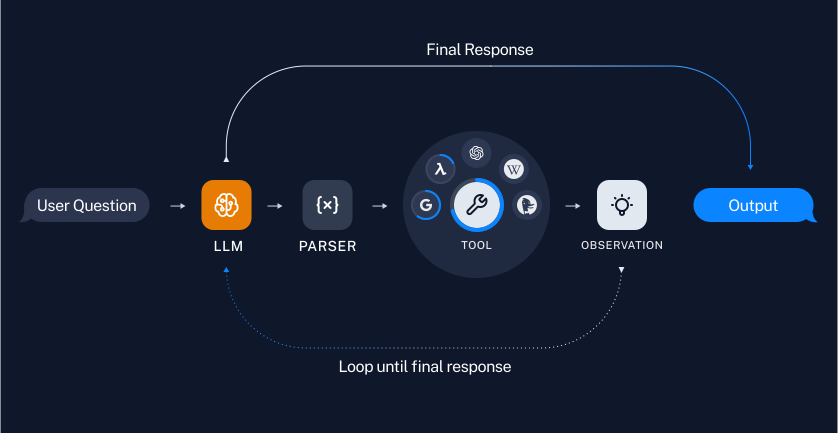

Авторы приходят к выводу, что использование простейших стратегий использования LLM даёт результаты не хуже использования агентов
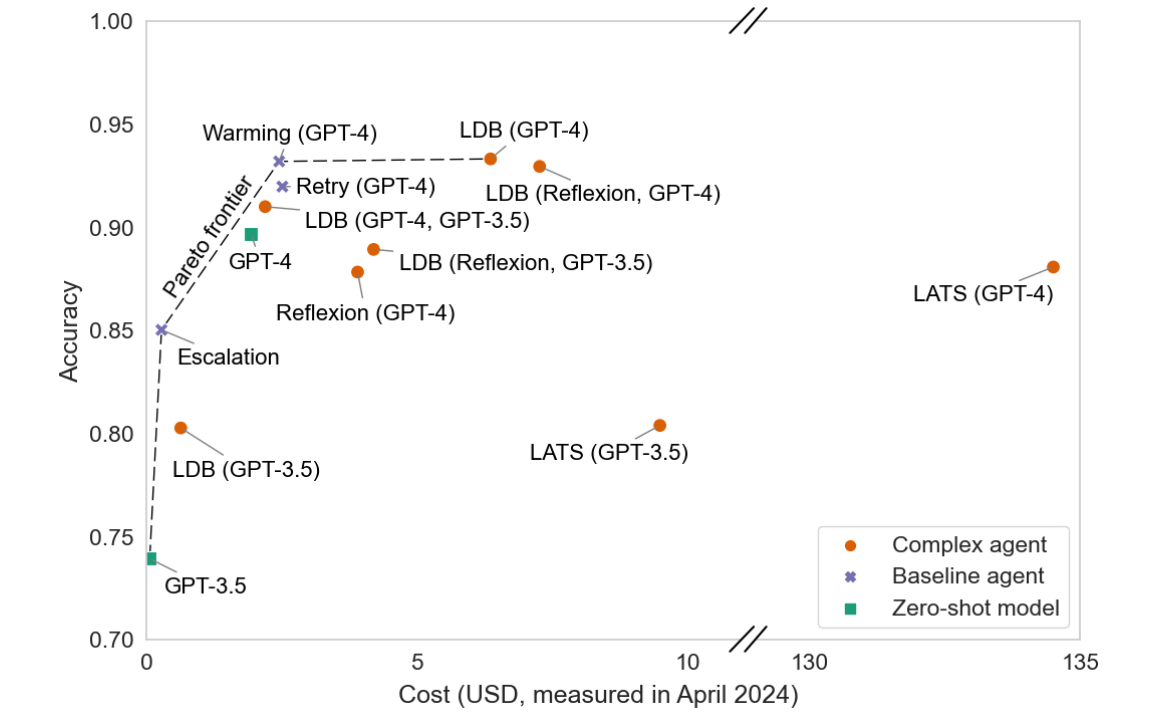

*Стратегии дизайна*

Рассмотрены варианты дизайна агента для поиска документов на бенчмарке HotPotQA
* Uncompiled - оптимизация запросов и инструкций отсутствует
* Formatting instructions only - даны инструкции как форматировать вывод для получения запросов на использование инструмента
* Few-shot - используется фреймворк DSPy для определения эффективных примеров использования на тренировочном наборе
* Random search - используется случайный поиск на части тренировочных данных для выбора наилучших few-shot примеров
* Joint optimization - перебор параметров и выбор наиболее успешных примеров из приведённых стратегий

Видно, что использование Joint optimization позволяет сильно снизить стоимость использования модели не теряя при этом сильно  точности.

Стоит отметить, что цена все равно гораздо больше, чем использование не агентных систем, т.к. в этом случае производится больше вызовов модели
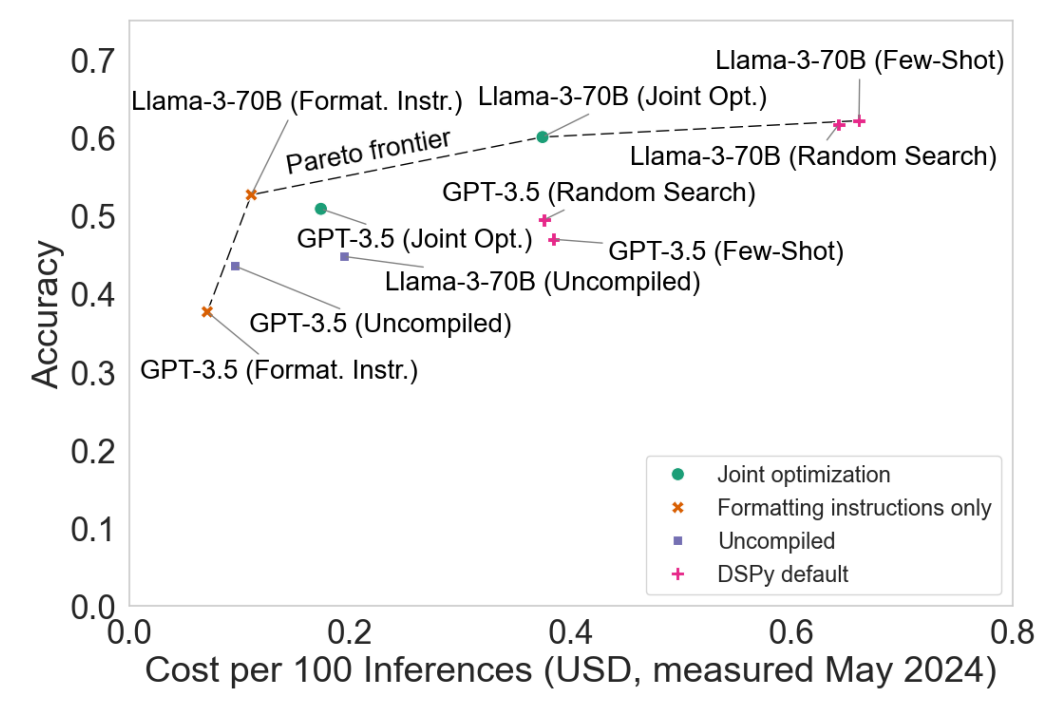

*Проблемы оценки точности моделей*

Бенчмарки бывают нескольких видов и нацелены на оценку способности выполнять действия разного вида:
* Distribution-specific - ограничены определённым спектром видов задач(например, задачи по математике)
* Task-specific - ограничены определённой задачей(заказ билета на самолет)
* Domain-general benchmarks - включают ВСЕ задачи в определённой области(поиск информации в интернете)
* General-purpose benchmarks - все задачи во всех областях

Создатели бенчмарков часто оставляют тесты полностью открытыми, что позволяет создателям агентов использовать "ручные" указания агентам, основываясь на конкретном бенчмарке.

Так, создатели агента STeP смогли превзойти результаты конкурентов на бенчмарке WebArena(бенчмарк, нацеленный на выполнение различных действий в интернете: покупка билета, публикация поста, поиск на карте) в два раза. Одним из приёмов, который они использовали: если запрос требует выполнения действия в Reddit, агент выполняет переход на личную страницу простым изменением адреса страницы, а не навигацией по сайту. Данный подход не предусматривает изменения расположения личной страницы.